In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import scipy
import random
import matplotlib.image as mpimg
import networkx as nx

### DEFINING FUNCTIONS

## Constructing ground truth matrices

In [2]:
def get_ground_truth_dict():
    
    c_2_0 = np.random.uniform(0.2,1)
    c_2_1 = np.random.uniform(0.2,1)
    c_1_0 = np.random.uniform(0.2,1)
    c5 = np.random.uniform(0.2,1)
    
    
    ground_truth_dict = {'common_input':np.array([[0, 0, 0],
                                                     [0, 0, 0],
                                                     [c_2_0, c_2_1, 0]]),
                         
                         'indirect_connections':np.array([[0, 0, 0],
                                                          [c_1_0, 0, 0],
                                                          [0, c_2_1,  0]]),
                         
                         'volume_conduction':np.array([[0, 0, 0],
                                                [0, 0, 0],
                                                [c_2_0, 0, 0]])}

    return ground_truth_dict

### Setting signal parameters

In [3]:
confounder_list = ['common_input', 'indirect_connections', 'volume_conduction']

def simulate_confounder(confounder):

    #setting parameters of signal
    sfreq = 250 # Hz
    tmin = 0 # s
    tmax = 100 # s
    time = np.arange(tmin, tmax, 1/sfreq) 

    f0 = np.random.randint(1,41)  
    f1 = np.random.randint(1,41)  
    f2 = np.random.randint(1,41)  

    
    #signals of 100s duration, 250 Hz sampling frequency, randomly chosen frequency
    signal0 = np.sin(2*np.pi*f0*time)
    signal1 = np.sin(2*np.pi*f1*time)
    signal2 = np.sin(2*np.pi*f2*time)

    #random white noise time series
    noise0 = np.random.randn(len(time))
    noise1 = np.random.randn(len(time))
    noise2 = np.random.randn(len(time))

    #gains
    g0 = g1 = g2 = 1

    
    #Factor scaling amplitude of noise
    alpha0 = np.random.uniform(0.01, 0.5)
    alpha1 = np.random.uniform(0.01, 0.5)
    alpha2 = np.random.uniform(0.01, 0.5)

    
    #signal to noise ratio
    snr0 = g0/alpha0
    snr1 = g1/alpha1
    snr2 = g2/alpha2

    #phase
    phase_2_0 = np.random.uniform(0,2)*np.pi
    phase_2_1 = np.random.uniform(0,2)*np.pi
    phase_0_1 = np.random.uniform(0,2)*np.pi

    #delays in seconds
    tau2_0 = phase_2_0/(2*np.pi*f0) #from 3 to 1
    tau2_1 = phase_2_1/(2*np.pi*f1) #from 3 to 2
    tau0_1 = phase_0_1/(2*np.pi*f2) #from 1 to 2
    
    #Time lags in samples
    lag2_0 = np.int64(np.round(tau2_0*f0))
    lag2_1 = np.int64(np.round(tau2_1*f1))
    lag0_1 = np.int64(np.round(tau0_1*f2))

    
    #c values
    c_2_0 = get_ground_truth_dict()[confounder][2][0]
    c_2_1 = get_ground_truth_dict()[confounder][2][1]
    c_0_1 = get_ground_truth_dict()[confounder][1][0]
    
    y2 = (g0*signal2) + noise2*snr2
    y0 = (g1*signal0) + noise0*snr0 + c_2_0*np.roll(y2, lag2_0)
    y1 = (g2*signal1) + noise1*snr1 + c_2_1*np.roll(y2, lag2_1) + c_0_1*np.roll(y0, lag0_1)

    if confounder == 'volume_conduction':
        L = np.random.uniform(-1,1,size=(3,3))
    else:
        L = np.identity(3)

    

    z0, z1, z2 = L @ np.array([y0, y1, y2])

    dict_signals = {"f0":f0, "f1":f1, "f2":f2, "signals":[z0,z1,z2]}

    return dict_signals

### Simulating signals

In [4]:
def mne_raw(signals):
    sim_data = np.array(signals)
    info = mne.create_info(ch_names=["ch_0", "ch_1", "ch_2"], ch_types=["eeg"]*3, sfreq=250)
    mne_raw = mne.io.RawArray(sim_data, info)
    
    return mne_raw

### Estimating connectivity

In [5]:
def estimate_connectivity(method, confounder):

    confounder_simulated = simulate_confounder(confounder)

    f0 = confounder_simulated["f0"]
    f1 = confounder_simulated["f1"]
    f2 = confounder_simulated["f2"]
    
    ground_truth = get_ground_truth_dict()[confounder]

    matrix_indices = list(zip([1,2,2],[0,0,1]))

    delta = 1

    simulated_data = confounder_simulated["signals"]
        
    epochs = mne.make_fixed_length_epochs(mne_raw(simulated_data), duration=1)

    if method == "imaginary_coherence" or method in directed_methods:
        
        m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=250)
        c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
        con = getattr(c, method)()
        f0_con = np.nan_to_num(con.squeeze())[f0-delta:f0+delta].transpose(1,2,0)
        f1_con = np.nan_to_num(con.squeeze())[f1-delta:f1+delta].transpose(1,2,0)
        f2_con = np.nan_to_num(con.squeeze())[f2-delta:f2+delta].transpose(1,2,0)
        con_mat = np.array([f0_con, f1_con, f2_con])
        con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())
        con_mat_normalized = con_mat_normalized.mean(axis=3).mean(axis=2)

    else:

        mne_con = spectral_connectivity_epochs(epochs, method=method, sfreq=250, fmin=(f0-delta, f1-delta, f2-delta), fmax=(f0+delta, f1+delta, f2+delta), fskip=0, 
                                                   faverage=True,mt_low_bias=True, block_size=1000, n_jobs=1,verbose=None)
        
        
        con_mat = mne_con.get_data(output="dense")

        con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())

        con_mat_normalized = con_mat_normalized.mean(2)
        
    return con_mat_normalized

### COMPILING ESTIMATE AND GROUND-TRUTH DICTIONARIES

In [6]:
#FUNCTIONAL CONNECTIVITY

In [6]:
undirected_methods = ['coh', 'ciplv','wpli2_debiased','imaginary_coherence']

directed_methods = ['generalized_partial_directed_coherence', 
                    'direct_directed_transfer_function', 
                    'pairwise_spectral_granger_prediction']

all_methods = undirected_methods + directed_methods

In [7]:
%%capture
edge_lists_undirected = {}
for confounder in confounder_list:
    edge_lists = {}
    for method in undirected_methods:
        edges_list = []
        for i in range(100):
            con_mat_normalized = estimate_connectivity(method,confounder)
            edges = [round(con_mat_normalized[1][0],2), round(con_mat_normalized[2][1],2), round(con_mat_normalized[2][0],2)]
            edges_list.append(edges)
        mean_edges = np.array(edges_list)
        edge_lists[method] = np.round(mean_edges.mean(axis=0),2)
    edge_lists_undirected[confounder] = edge_lists

In [12]:
edge_lists_undirected

{'common_input': {'coh': array([0.33, 0.68, 0.7 ]),
  'ciplv': array([0.35, 0.5 , 0.5 ]),
  'wpli2_debiased': array([0.27, 0.4 , 0.43]),
  'imaginary_coherence': array([0.22, 0.26, 0.28])},
 'indirect_connections': {'coh': array([0.67, 0.63, 0.08]),
  'ciplv': array([0.49, 0.5 , 0.22]),
  'wpli2_debiased': array([0.4 , 0.41, 0.12]),
  'imaginary_coherence': array([0.2 , 0.29, 0.2 ])},
 'volume_conduction': {'coh': array([0.74, 0.77, 0.76]),
  'ciplv': array([0.54, 0.53, 0.56]),
  'wpli2_debiased': array([0.36, 0.4 , 0.38]),
  'imaginary_coherence': array([0.27, 0.3 , 0.29])}}

In [13]:
edge_list_1 = [('Y0','Y1',{'w':'A1'}),('Y1','Y2',{'w':'B1'}),('Y0','Y2',{'w':'C1'})]

edge_list_2 = [('Y1','Y0',{'w':'A2'}),('Y2','Y1',{'w':'B2'}),('Y2','Y0',{'w':'C2'})]

## Common input

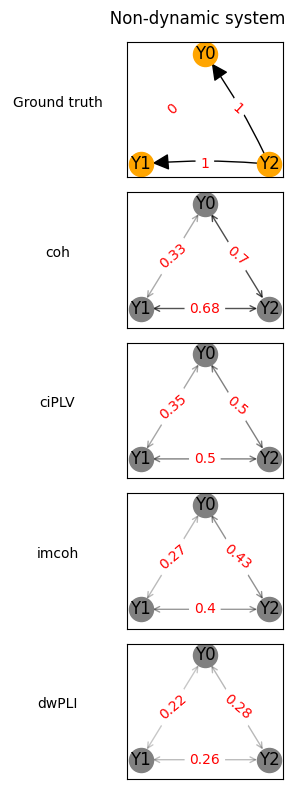

In [15]:
fig, axes = plt.subplots(5,1,figsize=(3,8))

G = nx.DiGraph()

G.add_edges_from(edge_list_1)
pos=nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,1,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y1','Y0'):0,('Y2','Y1'):1,('Y2','Y0'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])
#axes[0].set_title('Common input confounder',fontsize=11)

for ax,method in zip(list(range(1,5)),undirected_methods):
    G = nx.DiGraph()
    edge_list = [('Y0','Y1',{'w':'A1'}),
                 ('Y1','Y2',{'w':'B1'}),
                 ('Y0','Y2',{'w':'C1'})]
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G,seed=5)
    pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
    
    alpha = edge_lists_undirected['common_input'][method]
    nx.draw_networkx_edges(G, pos, ax=axes[ax], edgelist=edge_list, alpha=alpha,arrowstyle='<->')
    nx.draw_networkx_edge_labels(G, pos, ax=axes[ax], edge_labels={('Y0','Y1'):alpha[0],('Y1','Y2'):alpha[1],('Y0','Y2'):alpha[2]},font_color='red')
    arc_rad = 0.05
    nx.draw_networkx_nodes(G, pos, ax=axes[ax], node_color='grey',alpha=1.0)
    nx.draw_networkx_labels(G, pos, ax=axes[ax])

axes[0].set_ylabel(('Ground truth'), rotation='horizontal',labelpad=50)
axes[1].set_ylabel(('coh'), rotation='horizontal',labelpad=50)
axes[2].set_ylabel(('ciPLV'), rotation='horizontal',labelpad=50)
axes[3].set_ylabel(('imcoh'), rotation='horizontal',labelpad=50)
axes[4].set_ylabel(('dwPLI'), rotation='horizontal',labelpad=50)

fig.suptitle('                   Non-dynamic system')
fig.tight_layout()
plt.savefig('topo_func_comm_non_dyn.png',dpi=300)

## Indirect connections

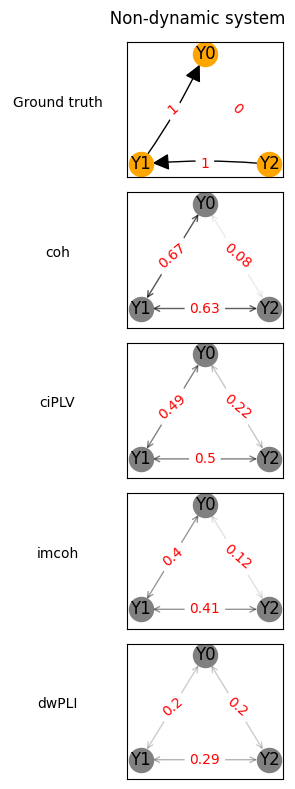

In [17]:
fig, axes = plt.subplots(5,1,figsize=(3,8))

G = nx.DiGraph()

G.add_edges_from(edge_list_1)
pos=nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[1,1,0],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y1','Y0'):1,('Y2','Y1'):1,('Y2','Y0'):0},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])
#axes[0].set_title('Common input confounder',fontsize=11)

for ax,method in zip(list(range(1,5)),undirected_methods):
    G = nx.DiGraph()
    edge_list = [('Y0','Y1',{'w':'A1'}),
                 ('Y1','Y2',{'w':'B1'}),
                 ('Y0','Y2',{'w':'C1'})]
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G,seed=5)
    pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
    
    alpha = edge_lists_undirected['indirect_connections'][method]
    nx.draw_networkx_edges(G, pos, ax=axes[ax], edgelist=edge_list, alpha=alpha,arrowstyle='<->')
    nx.draw_networkx_edge_labels(G, pos, ax=axes[ax], edge_labels={('Y0','Y1'):alpha[0],('Y1','Y2'):alpha[1],('Y0','Y2'):alpha[2]},font_color='red')
    arc_rad = 0.05
    nx.draw_networkx_nodes(G, pos, ax=axes[ax], node_color='grey',alpha=1.0)
    nx.draw_networkx_labels(G, pos, ax=axes[ax])

axes[0].set_ylabel(('Ground truth'), rotation='horizontal',labelpad=50)
axes[1].set_ylabel(('coh'), rotation='horizontal',labelpad=50)
axes[2].set_ylabel(('ciPLV'), rotation='horizontal',labelpad=50)
axes[3].set_ylabel(('imcoh'), rotation='horizontal',labelpad=50)
axes[4].set_ylabel(('dwPLI'), rotation='horizontal',labelpad=50)

fig.suptitle('                   Non-dynamic system')
fig.tight_layout()
plt.savefig('topo_func_ind_non_dyn.png',dpi=300)

## Volume conduction

In [ ]:
fig, axes = plt.subplots(5,1,figsize=(3,8))

G = nx.Graph()
edge_list = [('Y0','Y1',{'w':'A1'}),
                 ('Y1','Y2',{'w':'B1'}),
                 ('Y0','Y2',{'w':'C1'})]
G.add_edges_from(edge_list)
pos = nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list, alpha=[0,0,0])
arc_rad = 0.05
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y1','Y0'):0,('Y2','Y1'):0,('Y2','Y0'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0], node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])


for ax,method in zip(list(range(1,5)),undirected_methods):
    G = nx.DiGraph()
     edge_list = [('Y0','Y1',{'w':'A1'}),
                 ('Y1','Y2',{'w':'B1'}),
                 ('Y0','Y2',{'w':'C1'})]
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G,seed=5)
    pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
    
    alpha = edge_lists_undirected['volume_conduction'][method]
    nx.draw_networkx_edges(G, pos, ax=axes[ax], edgelist=edge_list, alpha=alpha,arrowstyle='<->')
    nx.draw_networkx_edge_labels(G, pos, ax=axes[ax], edge_labels={('Y0','Y1'):alpha[0],('Y1','Y2'):alpha[1],('Y0','Y2'):alpha[2]},font_color='red')
    arc_rad = 0.05
    nx.draw_networkx_nodes(G, pos, ax=axes[ax], node_color='grey',alpha=1.0)
    nx.draw_networkx_labels(G, pos, ax=axes[ax])

axes[0].set_title('Non-dynamic system')
axes[0].set_ylabel(('Ground truth'), rotation='horizontal',labelpad=50)
axes[1].set_ylabel(('coh'), rotation='horizontal',labelpad=50)
axes[2].set_ylabel(('ciPLV'), rotation='horizontal',labelpad=50)
axes[3].set_ylabel(('imcoh'), rotation='horizontal',labelpad=50)
axes[4].set_ylabel(('dwPLI'), rotation='horizontal',labelpad=50)

fig.tight_layout()
plt.savefig('topo_func_vol_non_dyn.png',dpi=300)